## How are $C_{\tau}$ values related to the initial concentration of RNA in a sample

In qPCR, RNA is labelled with a fluorescent dye, which can be detected, when the signal intensity is high enough, i.e. when enough copies of a gene are present. This is achieved by PCR, which amplifies the signal

The differential equation for this is the following

$$\frac{dR}{dt} = R \times \frac{1}{C_{\tau}}$$
where $C_{\tau}$ is the time it takes for a RNA to be copied. 

Meaning that for each replication cycle, the number of RNA copies doubles, This equation can be solved 

$$ R(t) = R_0~e^{\frac{t}{C_{\tau}}}$$

If the absolute time is not relevant (this is the case for qPCR), the equation can be reformulated in units of $C_{\tau}$

$$\frac{dR}{dC_{\tau}} = R$$
$$R(C_{\tau}) = R_0~e^{C_{\tau}}$$

In a qPCR analysis, $R(C_{\tau})$ is fixed to a certain threshold, and $C_{\tau}$ is recorded, when $R(C_{\tau})$ is reached. Then $R_0$ can be calculated from the eq.
Importantly, e can of course be any growth rate. It makes sense that the growth model is smaller than the $e$. In the work with PCR analytics a base of 2 is often used.



In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

rng = np.random.default_rng(1231)

c_t = np.linspace(0, 50, 500)

# amplification model
R = lambda r0, c_t: r0 * 2 ** c_t

# growth rate, scaled by np.log2(e) to account for base 2 of amplification model
k = 1 / np.log2(np.exp(1))  

def rna_amplification(R, t):
    """R """
    return R * k

R_0 = 1
R_t = odeint(rna_amplification, y0=R_0, t=c_t)



14.609640474436812 16.609640474436812
known fold_change: 0.25
estimated_change 2.0
estimated_fold_change 0.25
estimated_log2_fold_change -2.0


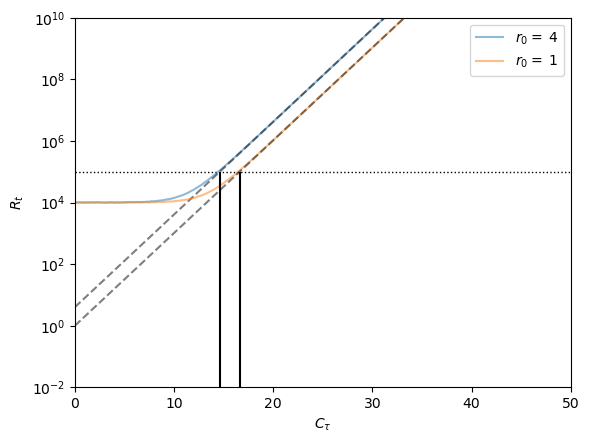

In [2]:
# calculation example
r0_treatment = 1
r0_control = 4
r_thresh = 1e5

ax = plt.subplot(111)
ax.set_xlabel(r"$C_{\tau}$")
ax.set_ylabel(r"$R_t$")
ax.set_ylim(0.01, 1e10)
ax.set_xlim(0, 50)
ax.hlines(1e5, 0, 50, color="black", ls="dotted", lw=1)
ax.set_yscale("log")

for r0 in [r0_control, r0_treatment]:
    R_t = odeint(rna_amplification, y0=r0, t=c_t)

    # add noise from measurement to show that measurements below baseline are
    # not useful
    R_t_noisy = rng.normal(R_t + 1e4, 1e2)
    ax.plot(c_t, R_t_noisy, alpha=.5, label=f"$r_0 =$ {r0}")

    # analytic solution
    ax.plot(c_t, R(r0, c_t), ls="--", color="black", alpha=.5)

ax.legend()

# calculating the C_t values
C_t_control = np.log2(r_thresh / r0_control)
C_t_treatment = np.log2(r_thresh / r0_treatment)
ax.vlines(C_t_control, 1e-2, r_thresh, color="black")
ax.vlines(C_t_treatment, 1e-2, r_thresh, color="black")

print(C_t_control, C_t_treatment)
print("known fold_change:", r0_treatment / r0_control)

# estimate fold change from C_t data
fold_change = 2 ** (- (C_t_treatment - C_t_control))
print("estimated_change", C_t_treatment - C_t_control)
print("estimated_fold_change", fold_change) 
print("estimated_log2_fold_change", np.log2(fold_change))


| ⚠️ | Note that the base of the calculation depends on the assumed growth (amplification) model. I guess this should be calibrated, but if a base of 2 normally is okay, than ok |
|---|---------------------------------------|

### calculation details

In [3]:
r0_proportional_control = 2 ** (-C_t_control)
r0_proportional_treatment = 2 ** (-C_t_treatment)

print(r0_proportional_control, r0_proportional_treatment)
print("proportional_fold_change:", r0_proportional_treatment/ r0_proportional_control)

3.999999999999998e-05 9.999999999999996e-06
proportional_fold_change: 0.25


In [4]:
# simpler calculation

fold_change = 2 ** (- (C_t_treatment - C_t_control))
print(fold_change)

0.25


### calculating the cycle time and $R_0$

Theoretically $R_0$ would be the most interesting quantitiy, as it would be the number of RNA copies, present in the sample presented to the qPCR machine. This could then by simple agebra converted to the quantity of RNA present in the organism. By encorporating a mathematical error model of the measurement process, the true underlying signal could be recovered. However, there seem to be so many small steps involved, that measuring the true value seems impractical for a modeling purpose. The solution should therefore be to remain with the fold-change or deviation measuremnet. 

The question is how to correctly model this measurement.

### Interpreting fold change in terms of a model

in order to correctly model the differential expression of a gene signal, it makes sense to understand how hypothetical $R_0$ and $C_{\tau}$ values relate to fold change values

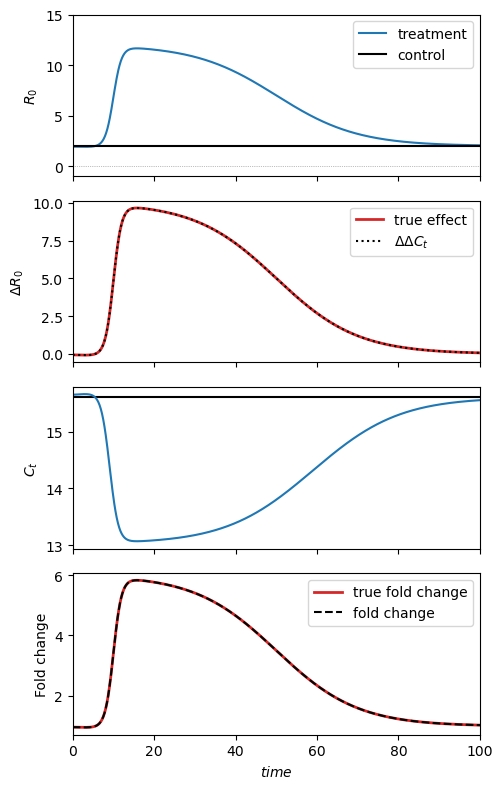

In [10]:
import sys; sys.path.append("..")

t = np.linspace(0,100, 1000)

def baseline_expression(t):
    # could be modeled as a gaussian random walk
    return 0.1 * t + 1


def baseline_expression(t):
    # could be modeled as a gaussian random walk
    return np.repeat(2, len(t))

def stylized_upregulation_pulse(t):
    activation = 10 / (1 + np.exp(-(t - 10)))
    repression = 10 / (1 + np.exp(-(t - 50) / 10))
    return activation - repression

r0_control =  baseline_expression(t)
r0_effect = stylized_upregulation_pulse(t)
r0_treatment = r0_effect + r0_control
r0_effect_ratio = r0_treatment / r0_control
C_t_control = np.log2(r_thresh / r0_control)
C_t_treatment = np.log2(r_thresh / r0_treatment)
delta_C_t = - (C_t_treatment - C_t_control)
# I can recover the true signal if I have the threshold information from the
# qPCR experiment
C_t_ratio = r_thresh * (2 ** - C_t_treatment - 2 ** - C_t_control)


fold_change = 2 ** (delta_C_t)

fig, (ax, ax1, ax2, ax3) = plt.subplots(4, 1, sharex=True, figsize=(5,8))
ax.set_ylim(-1,15)
ax.set_xlim(0,100)
ax3.set_xlabel(r"$time$")
ax.set_ylabel(r"$R_0$")
ax2.set_ylabel(r"$C_t$")
ax1.set_ylabel(r"$\Delta R_0$")
ax3.set_ylabel(r"Fold change")
ax.hlines(0, 0, 100, color="grey", lw=0.5, ls="dotted")
ax.plot(t, r0_treatment, label="treatment")
ax.plot(t, r0_control, label="control", color="black")
ax1.plot(t, r0_effect, lw=2, label="true effect", color="tab:red")
ax3.plot(t, r0_effect_ratio, lw=2, label="true fold change", color="tab:red")
ax2.plot(t, C_t_control, label="control", color="black")
ax2.plot(t, C_t_treatment, label="control", color="tab:blue")
ax3.plot(t, fold_change, color="black", ls="--", label="fold change")
ax1.plot(t, C_t_ratio , color="black", ls="dotted", label=r"$\Delta\Delta C_t$")
ax.legend()
ax1.legend()
ax3.legend()
fig.tight_layout()
fig.savefig("../../../results/plots/rna_ct_foldchange_relationship.png")


## RNA Expression models

The following sections will develop and explore RNA expression models

### RNA baseline models

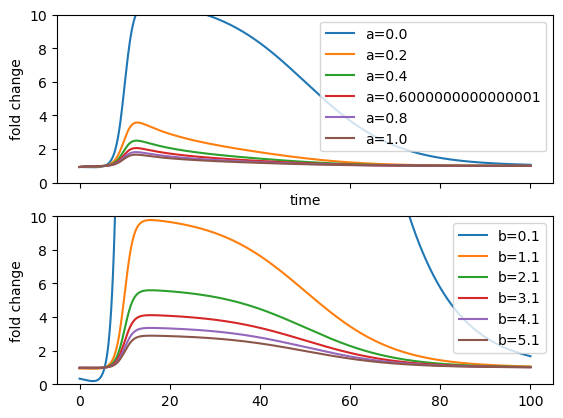

In [6]:
from functools import partial


def baseline_linear(t, a, b):
    # could be modeled as a gaussian random walk
    return a * t + b


def fold_change_model(baseline_model, pulse_model):
    r0_base = baseline_model(t)
    r0_pulse = pulse_model(t)

    # calculate the effect ratio, this is as shown above equal to 
    fold_change = (r0_base + r0_pulse) / r0_base

    return fold_change

fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
ax1.set_xlabel("time")
ax1.set_ylabel("fold change")
ax2.set_ylabel("fold change")
ax1.set_ylim(0, 10)

for a in np.linspace(0, 1, 6):
    fc = fold_change_model(
        baseline_model=partial(baseline_linear, a=a, b=1),
        pulse_model=stylized_upregulation_pulse,
    )
    ax1.plot(t, fc, label=f"a={a}")

for b in np.linspace(0.1, 5.1, 6):
    fc = fold_change_model(
        baseline_model=partial(baseline_linear, a=0, b=b),
        pulse_model=stylized_upregulation_pulse,
    )
    ax2.plot(t, fc, label=f"b={b}")

ax1.legend()
ax2.legend()


As shown above the constant baseline leads to a more plateu like pulse while the increasing baseline makes the pulse more peaked. Baseline data from control organisms show that the baseline is somewhat cyclic but has a generally increasing trend, which is however not steep.

### RNA model with constant baseline and upregulating pulse

In [7]:

from scipy.integrate import odeint

def f(model, params, y0=(0,0)):
    res = odeint(
        func=model, 
        t=t,
        y0=y0,
        args=params,
    )

    return res

fold_change_model = lambda base, effect: (base + effect) / base

In [8]:
def rna_pulse_simplified(X, t, cext, r_ci, v_rt, z_ci, r_rt, r_rd):
    """No decay of Ci and constant external concentration"""
    Ci, R = X    
    dCi = cext * r_ci
    active = 0.5 + (1 / np.pi) * np.arctan(v_rt * (Ci - z_ci))
    dR = r_rt * active - R * r_rd
    return dCi, dR

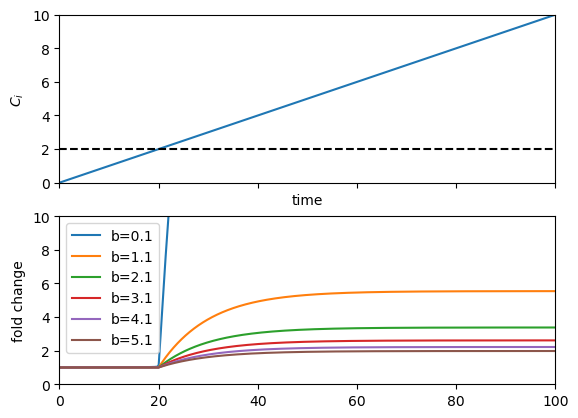

In [9]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True, sharey=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax1.set_ylim(0, 10)
ax1.set_xlim(t.min(), t.max())

cext = 10  # external concentration
r_ci = 0.01  # uptake rate of external concentration
v_rt = 1000  # speed of transcription activation
z_ci = 2  # threshold of ci for transcription activation
r_rt = 0.5  # transcription rate (this is a constant)
r_rd = 0.1  # decay rate of RNA

for b in np.linspace(0.1, 5.1, 6):
    pulse_model, = f(rna_pulse_simplified, (cext, r_ci, v_rt, z_ci, r_rt, r_rd)),

    fc = fold_change_model(
        base=baseline_linear(t, a=0, b=b),
        effect=pulse_model[:, 1].T,
    )
    ax2.plot(t, fc, label=f"b={b}")

ax1.plot(t, pulse_model[:, 0].T)
ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")
ax2.legend()

The above model is not capable to model peaking RNA expression, as the rate expression rate $r_{rt}$ is constant (0.5) after the threshold has been reached. It is then only stabilized due to the "natural" decay rate of the RNA $r_{rd}$. Only if the internal concentration can be metabolized, can the level drop.

In [10]:
def rna_pulse_metabo(X, t, cext, r_ci, v_rt, z_ci, r_rt, r_rd, r_m):
    """No decay of Ci and constant external concentration"""
    Ci, R = X    
    dCi = cext * r_ci - r_m * R * Ci
    active = 0.5 + (1 / np.pi) * np.arctan(v_rt * (Ci - z_ci))
    dR = r_rt * active - R * r_rd
    return dCi, dR

In this model, the term $r_m R C_i$ was introduced, which is the metabolization flux dependent on the level of RNA expression and the metabolization rate

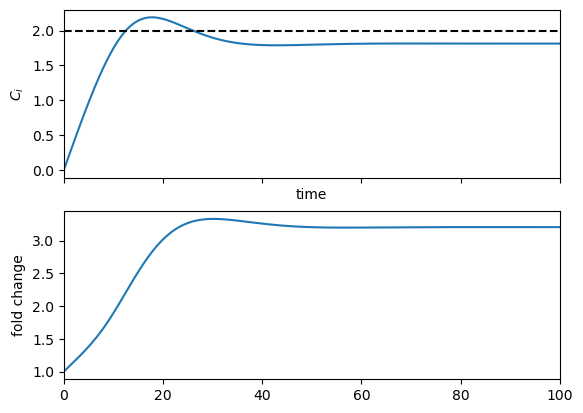

In [11]:
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax1.set_xlim(t.min(), t.max())

cext = 10  # external concentration
r_ci = 0.02  # uptake rate of external concentration
v_rt = 1  # speed of transcription activation
z_ci = 2  # threshold of ci for transcription activation
r_rt = 0.5  # transcription rate (this is a constant)
r_rd = 0.1  # decay rate of RNA
r_m = 0.05  # metabolization rate
a = 0.00  # slope of baseline model
b = 1  # baseline expression of model

pulse_model, = f(rna_pulse_metabo, (cext, r_ci, v_rt, z_ci, r_rt, r_rd, r_m)),

fc = fold_change_model(
    base=baseline_linear(t, a=a, b=b),
    effect=pulse_model[:, 1].T,
)
ax2.plot(t, fc, label=f"b={b}")

ax1.plot(t, pulse_model[:, 0].T)
ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")

The above model is very much capable of modeling the assumed gene expression dynamic. However, looking at the data, it appears that the gene expression rates are quickly reduced to the baseline level again and do not stay upregulated for long. 

It would make sense to have a decay overshoot below the threshold. Because then the genes do not have to be activated again and again.

## Delayed decay model

In [12]:
def rna_pulse_delayed_decay(X, t, cext, r_ci, v_rt, z_ci, r_rt, r_re, r_dm, r_dr):
    """No decay of Ci and constant external concentration"""
    Ci, R, M = X    
    dCi = cext * r_ci - M * Ci
    active = 0.5 + (1 / np.pi) * np.arctan(v_rt * (Ci - z_ci))
    dR = r_rt * active - R * r_dr
    dM = r_re * R - M * r_dm
    return dCi, dR, dM

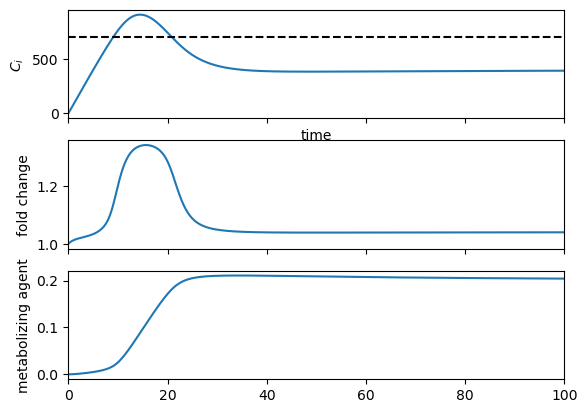

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax3.set_ylabel("metabolizing agent")
ax1.set_xlim(t.min(), t.max())

cext = 10  # external concentration
r_ci = 8  # uptake rate of external concentration
v_rt = 0.01 # speed of transcription activation
z_ci = 700  # threshold of ci for transcription activation
r_rt = 0.2  # transcription rate (this is a constant)
r_re = 0.1  # conversion rate of RNA to metabolization agent (e.g. protein)
r_dr = 1  # decay rate of RNA
r_dm = 0.01  # decay rate of protein
a = 0.00  # slope of baseline model
b = 0.5  # baseline expression of model

pulse_model, = f(rna_pulse_delayed_decay, (cext, r_ci, v_rt, z_ci, r_rt, r_re, r_dm, r_dr), y0=(0,0,0)),

fc = fold_change_model(
    base=baseline_linear(t, a=a, b=b),
    effect=pulse_model[:, 1].T,
)
ax3.plot(t, pulse_model[:,2].T)
ax2.plot(t, fc, label=f"b={b}")

ax1.plot(t, pulse_model[:, 0].T)
ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")

The above model assumes that the gene is not directly responsible to metabolize the compount but instead a 2nd compound (e.g. a protein) is responsible for eliminating the compound, which is more stable than the RNA itself. This way, expression can drop agian to zero while the concentration of the compound is effectively controlled.

The problem with this model is, that NRF expression after exposure to **Naproxen** and **Diclofenac** is somewhat different. Also it may be hard to explain dose response relationships in the expression.

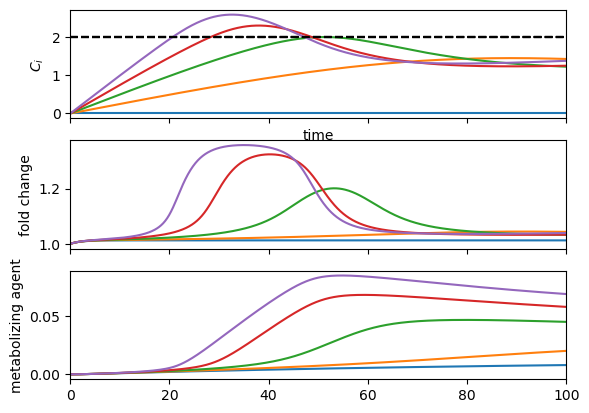

In [21]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax3.set_ylabel("metabolizing agent")
ax1.set_xlim(t.min(), t.max())

cext = 10  # external concentration
r_ci = 0.01 # uptake rate of external concentration
v_rt = 5 # speed of transcription activation
z_ci = 2  # threshold of ci for transcription activation
r_rt = 0.2  # transcription rate (this is a constant)
r_dr = 0.5  # decay rate of RNA
r_re = 0.01  # Protein transcription
r_dm = 0.01  # metabolization rate
a = 0.00  # slope of baseline model
b = 1  # baseline expression of model

for cext in np.linspace(0,10,5):

    pulse_model, = f(rna_pulse_delayed_decay, (cext, r_ci, v_rt, z_ci, r_rt, r_re, r_dm, r_dr), y0=(0,0,0)),

    fc = fold_change_model(
        base=baseline_linear(t, a=a, b=b),
        effect=pulse_model[:, 1].T,
    )
    ax3.plot(t, pulse_model[:,2].T)
    ax2.plot(t, fc, label=f"b={b}")

    ax1.plot(t, pulse_model[:, 0].T)
    ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")

The above is a very interesting model. It can model a small dose response relationship in the NRF expression, by using a smooth activation function as a step function. By doing so, also internal concentrations below the threshold will activate a gene expression response. The expression can return back to the baseline and it can be expressed multiple times.

**This could be empirically tested perhaps in vitro by measuring the gene expression**

### Irreversible damage (like with Naproxen)

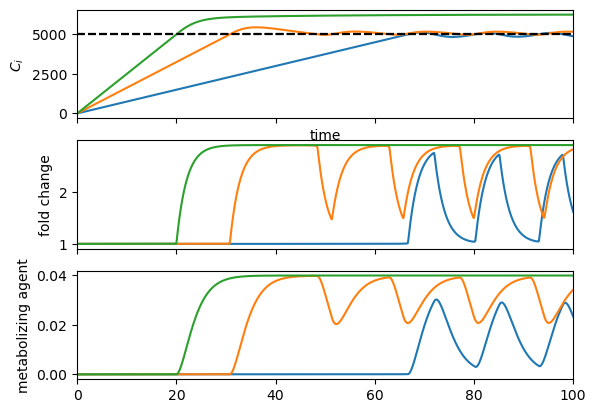

In [41]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax3.set_ylabel("metabolizing agent")
ax1.set_xlim(t.min(), t.max())

cext = 500  # external concentration
r_ci = 0.5  # uptake rate of external concentration
v_rt = 1 # speed of transcription activation
z_ci = 5000  # threshold of ci for transcription activation
r_rt = 0.2  # transcription rate (this is a constant)
r_re = 0.05  # decay rate of RNA
r_dr = 0.5  # decay rate of RNA
r_dm = 0.5  # metabolization rate
a = 0.00  # slope of baseline model
b = .21  # baseline expression of model

for cext in np.linspace(150,500,3):

    pulse_model, = f(rna_pulse_delayed_decay, (cext, r_ci, v_rt, z_ci, r_rt, r_re, r_dm, r_dr), y0=(0,0,0)),

    fc = fold_change_model(
        base=baseline_linear(t, a=a, b=b),
        effect=pulse_model[:, 1].T,
    )
    ax3.plot(t, pulse_model[:,2].T)
    ax2.plot(t, fc, label=f"b={b}")

    ax1.plot(t, pulse_model[:, 0].T)
    ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")

The above is the RNA same model for values that are rather in the range of Naproxen. Interestingly, v_rt seems to behave rather like a relative step size. Which of course makes sense. The slope should be realtive to the threshold and not absolute. Changed parameters were:
- $r_{ci}$, which is the uptake rate
- $v_{rt}$, the slope of the step. Was reduced by a factor of 1000, which is more or less proportional to the increase in threshold. So this makes sense
- $r_{dm}$, the decay rate of the metabolizing agent (protein) was increased, which is a somewhat dangerous assumption, because this of course would vary between substances. It could perhaps also be linked to the internal concentration, which would explain the change better. On a biological level this could be justified by assuming that the proteins or whatever is driving the metabolization is "consumed" by the toxicant.

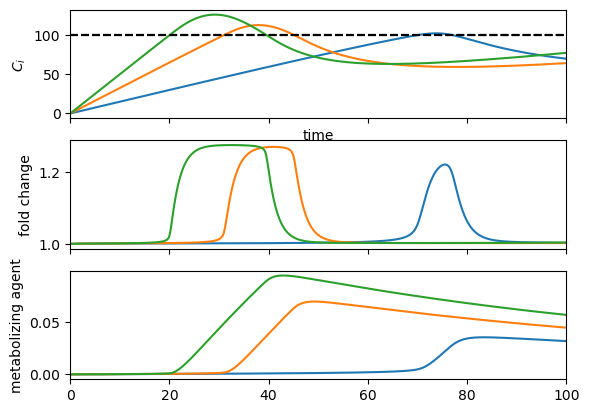

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, sharex=True)
ax1.set_xlabel("time")
ax1.set_ylabel(r"$C_i$")
ax2.set_ylabel("fold change")
ax3.set_ylabel("metabolizing agent")
ax1.set_xlim(t.min(), t.max())

cext = 5  # external concentration
r_ci = 0.01 # uptake rate of external concentration
v_rt = 1 # speed of transcription activation
z_ci = 100  # threshold of ci for transcription activation
r_rt = 0.16  # transcription rate (this is a constant)
r_dr = 0.57  # decay rate of RNA
r_re = 0.02  # protein ratxe of RNA
r_dm = 0.01  # metabolization rate
a = 0.00  # slope of baseline model
b = 1  # baseline expression of model

for cext in np.linspace(150,500,3):

    pulse_model, = f(rna_pulse_delayed_decay, (cext, r_ci, v_rt, z_ci, r_rt, r_re, r_dm, r_dr), y0=(0,0,0)),

    fc = fold_change_model(
        base=baseline_linear(t, a=a, b=b),
        effect=pulse_model[:, 1].T,
    )
    ax3.plot(t, pulse_model[:,2].T)
    ax2.plot(t, fc, label=f"b={b}")

    ax1.plot(t, pulse_model[:, 0].T)
    ax1.hlines(z_ci, t.min(), t.max(), ls="--", color="black")